In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilabel-classification-dataset/sample_submission.csv
/kaggle/input/multilabel-classification-dataset/train.csv
/kaggle/input/multilabel-classification-dataset/test.csv


In [2]:
df = pd.read_csv("/kaggle/input/multilabel-classification-dataset/train.csv")

In [3]:
def preprocess_input(df):
    
    def tokenize():
        pass
    def stemming():
        pass
    
    def get_id_from_text():
        pass
    def get_text_from_id():
        pass
        

In [4]:
label_tags = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']
label_tags
input_tags = ['TITLE', 'ABSTRACT']

**Data Preprocessing**

In [5]:
import tensorflow as tf
import tensorflow_text as tf_text
from sklearn.model_selection import train_test_split

2024-06-16 13:56:55.837481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 13:56:55.837613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 13:56:56.009524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
from tensorflow.keras.layers import TextVectorization
import re
import string
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.

def get_vectorize_layer(vocab_size=10000, sequence_length=100):
    vectorize_layer = TextVectorization(
        standardize=custom_standardization,
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=sequence_length)
    return vectorize_layer

def get_text_from_tokens(tensor, vocab):
    text = ""
    for i in tensor.numpy():
        if vocab[i]:
            text =text +  f" {vocab[i]}"

    return text
        
    

In [7]:
def get_labels(df, tags):
    labels = []
    for i, row in df.iterrows():
        encode = [row[j] for j in tags]
        labels.append(encode)
    return labels

def get_train_val_input_data(df, label_cols):
    train_data, valid_data = train_test_split(df, train_size=0.8, shuffle=True)
    train_title_data = list(train_data['TITLE'])
    train_abstract_data = list(train_data['ABSTRACT'])
    valid_title_data = list(valid_data['TITLE'])
    valid_abstract_data = list(valid_data['ABSTRACT'])
    train_labels = get_labels(train_data, label_cols)
    valid_labels = get_labels(valid_data, label_cols)
    input_data = {
        'train_data' : (train_title_data, train_abstract_data),
        'train_label' : train_labels,
        'valid_data' : (valid_title_data, valid_abstract_data),
        'valid_label': valid_labels
    }
    return input_data

In [8]:
def get_dataset(input_data, labels, title_vectorize_layer, abstract_vectorize_layer, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((input_data, labels)).map(lambda x,y : ((title_vectorize_layer(x[0]), abstract_vectorize_layer(x[1])), y)).batch(batch_size)
    return dataset

In [9]:
title_vectorize_layer = get_vectorize_layer(50000)
abstract_vectorize_layer = get_vectorize_layer(50000 ,sequence_length=200)

In [10]:
title_vectorize_layer.adapt(list(df['TITLE']))

In [11]:
abstract_vectorize_layer.adapt(list(df['ABSTRACT']))

In [12]:
#check sample representation : 
title_vectorize_layer(df['TITLE'][400])

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([   17, 10177,   471,    20,     5,    61,   895,   179,    11,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])>

In [13]:
input_data = get_train_val_input_data(df, label_tags)

In [14]:
train_data = get_dataset(input_data['train_data'], input_data['train_label'], title_vectorize_layer, abstract_vectorize_layer, 64)

In [15]:
valid_data = get_dataset(input_data['valid_data'], input_data['valid_label'], title_vectorize_layer, abstract_vectorize_layer, 64)

In [16]:
def get_model():
    input1, input2= tf.keras.layers.Input(shape=(100, ), name='title_input'), tf.keras.layers.Input(shape=(200, ), name='abstract_input')
#     inputs = tf.keras.layers.Concatenate(axis=-1, name='concatenate_layer')([input1, input2])
    title_embs = tf.keras.layers.Embedding(50000, 64, name='title_embedding_layer')(input1)
    abstract_embs = tf.keras.layers.Embedding(50000, 64, name='abstract_embedding_layer')(input2)
#     out = tf.keras.layers.GlobalAveragePooling1D()(embs)
    title_lstm = tf.keras.layers.LSTM(6, return_sequences=False, return_state=False)
    abstract_lstm = tf.keras.layers.LSTM(6, return_sequences=False, return_state=False)
    title_whole_seq_output = title_lstm(title_embs)
    abstract_whole_seq_output = abstract_lstm(abstract_embs)
    merge_layer = tf.keras.layers.Add()([title_whole_seq_output, abstract_whole_seq_output])
    outs = tf.keras.layers.Dense(6, activation='sigmoid')(merge_layer)
    
    return tf.keras.Model((input1, input2), outs)
    
def predict(model, title, abstract):
    title = title_vectorize_layer(title)
#     title = tf.expand_dims(title, 0)
    
    abstract = abstract_vectorize_layer(abstract)
#     abstract = tf.expand_dims(abstract, 0)
    print(title.get_shape(), abstract.get_shape())
    resp = model.predict((title, abstract))
    return resp


In [17]:
model = get_model()

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ title_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abstract_input      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_embedding_la… │ (None, 100, 64)   │  3,200,000 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abstract_embedding… │ (None, 200, 64)   │  3,200,000 │ abstract_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 6)         │      1,704 │ title_embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 6)         │      1,704 │ abstract_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 6)         │          0 │ lstm[0][0],       │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6)         │         42 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,403,450 (24.43 MB)

 Trainable params: 6,403,450 (24.43 MB)

 Non-trainable params: 0 (0.00 B)

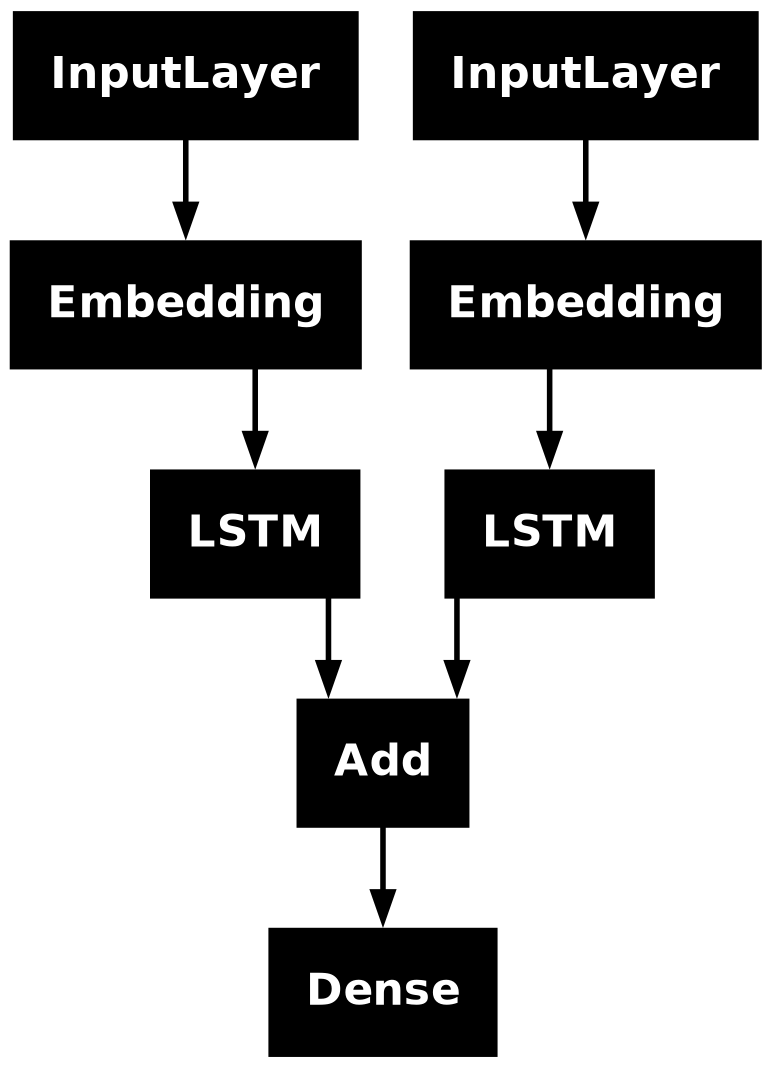

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
history = model.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - accuracy: 0.3989 - loss: 0.4922 - val_accuracy: 0.4138 - val_loss: 0.4367
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.4125 - loss: 0.4319 - val_accuracy: 0.4138 - val_loss: 0.4280
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.4245 - loss: 0.4052 - val_accuracy: 0.4870 - val_loss: 0.3883
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.5620 - loss: 0.3701 - val_accuracy: 0.5454 - val_loss: 0.3732
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.6014 - loss: 0.3487 - val_accuracy: 0.6000 - val_loss: 0.3623
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.6885 - loss: 0.3175 - val_accuracy: 0.7580 - val_loss: 0.2908
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.7900 - loss: 0.2479 - val_accuracy: 0.7476 - val_loss: 0.2796
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.8069 - loss: 0

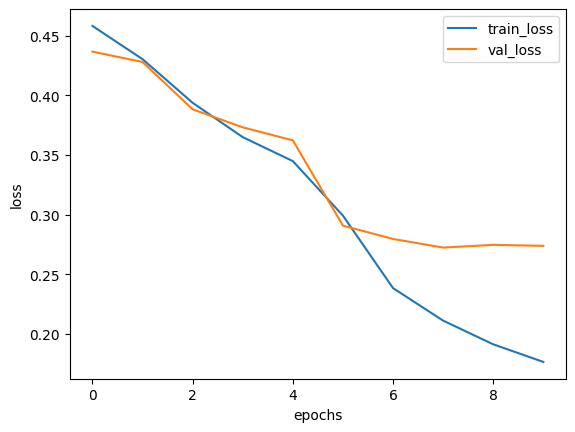

In [22]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(0, history.params['epochs'])], history.history['loss'], label='train_loss')
plt.plot([i for i in range(0, history.params['epochs'])], history.history['val_loss'], label='val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


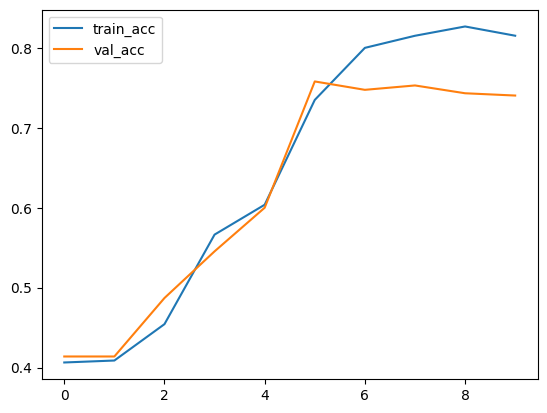

In [23]:
plt.plot([i for i in range(0, history.params['epochs'])], history.history['accuracy'], label='train_acc')
plt.plot([i for i in range(0, history.params['epochs'])], history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

**TEST DATASET PREDICTION**

In [24]:
test_df = pd.read_csv('/kaggle/input/multilabel-classification-dataset/test.csv')

In [25]:
test_preds = predict(model, test_df['TITLE'], test_df['ABSTRACT'])

(8989, 100) (8989, 200)
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


In [26]:
results = pd.DataFrame(test_preds, columns=label_tags)
for i in label_tags:
    results[i] = results[i].apply(lambda x: 1 if x >=0.5 else 0)

In [27]:
results['TITLE'] = test_df['TITLE']
results['ABSTRACT'] = test_df['ABSTRACT']

In [28]:
results

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE,ABSTRACT
0,0,0,0,1,0,0,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,0,1,0,0,0,0,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,1,0,0,0,0,0,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,0,1,0,0,0,0,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,1,0,0,1,0,0,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...
...,...,...,...,...,...,...,...,...
8984,1,0,0,0,0,0,Supporting mixed-datatype matrix multiplicatio...,We approach the problem of implementing mixe...
8985,0,0,0,0,0,0,An axiomatic basis for Blackwell optimality,In the theory of Markov decision processes (...
8986,1,0,0,0,0,0,GeneVis - An interactive visualization tool fo...,GeneVis is a web-based tool to visualize com...
8987,1,0,0,1,0,0,Quantifying the causal effect of speed cameras...,This paper quantifies the effect of speed ca...
